# Paso 1: Instalar y importar bibliotecas necesarias





In [1]:
!pip install opendatasets
import opendatasets as od
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paso 2: Descargar y explorar el conjunto de datos desde Kaggle


In [2]:
dataset_link = "https://www.kaggle.com/datasets/danielshanbalico/dog-emotion"
od.download(dataset_link)
dataset_dir = "./dog-emotion/Dog Emotion"

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: juandavidtriana.jdt@gmail.com
Your Kaggle Key: ··········


100%|██████████| 155M/155M [00:03<00:00, 42.3MB/s]


# Paso 3: Visualizar algunas imágenes del conjunto de datos


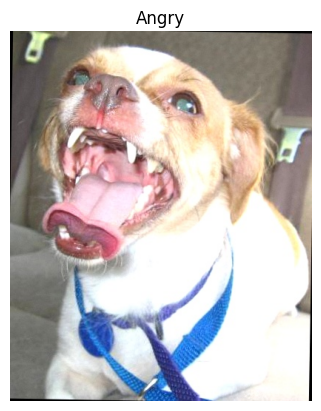

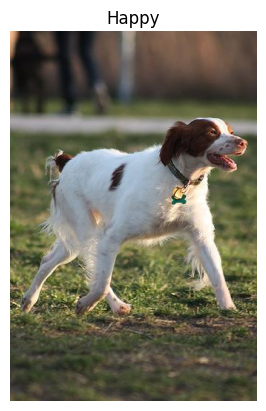

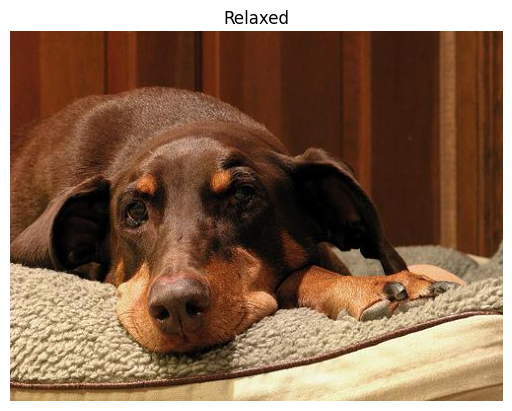

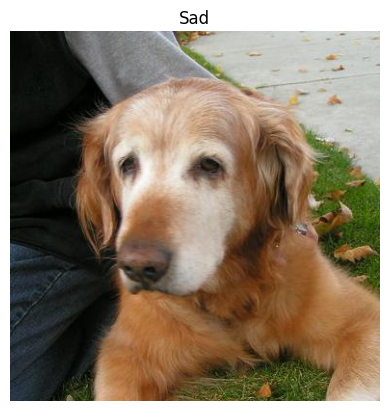

In [3]:
folders = ["angry", "happy", "relaxed", "sad"]

def show_images(folder):
    folder_path = os.path.join(dataset_dir, folder)
    image_file = os.listdir(folder_path)[0]
    image = cv2.imread(os.path.join(folder_path, image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(folder.capitalize())
    plt.axis('off')
    plt.show()

for folder in folders:
    show_images(folder)

# Paso 4: Preprocesamiento de datos


In [4]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (150, 150))
    return resized_image

data_pairs = []

for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    image_files = os.listdir(folder_path)
    for image_file in tqdm(image_files, desc=f"Procesando {folder}"):
        image_path = os.path.join(folder_path, image_file)
        processed_image = preprocess_image(image_path)
        data_pairs.append((processed_image, folder))

Procesando sad: 100%|██████████| 1000/1000 [00:04<00:00, 243.85it/s]


# Paso 5: Visualizar imágenes preprocesadas


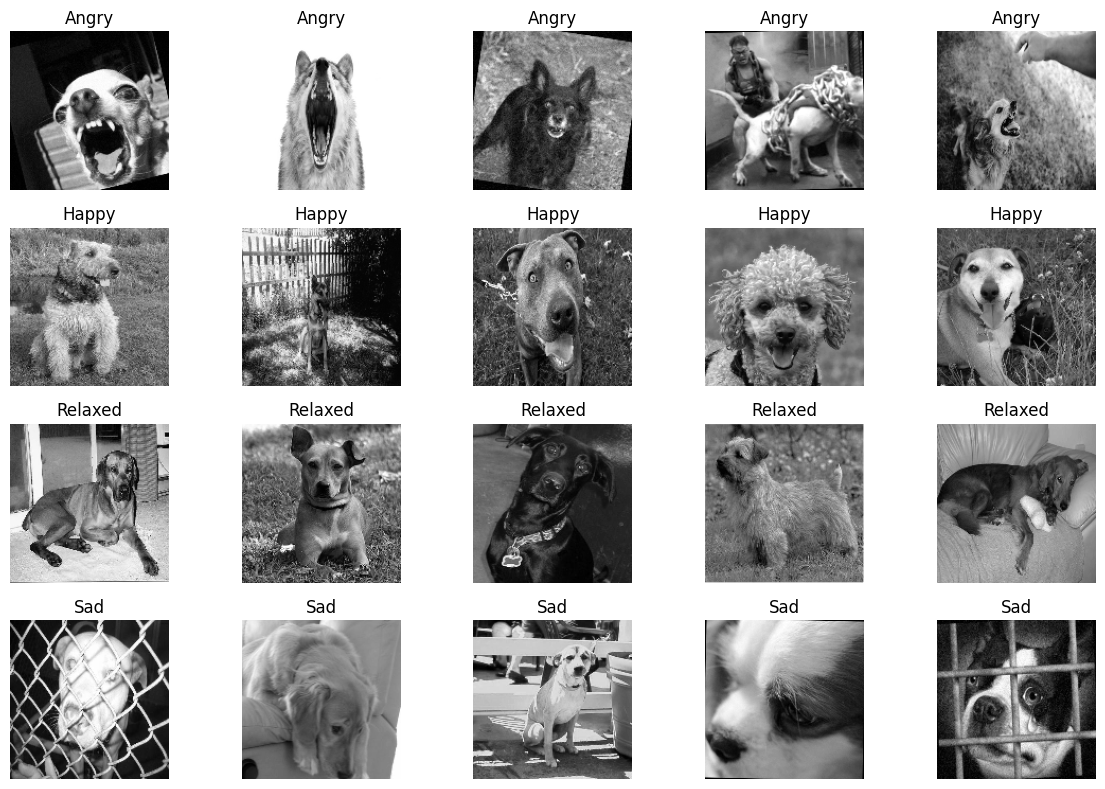

In [ ]:
num_images_per_emotion = 5
plt.figure(figsize=(12, 8))
for i, emotion in enumerate(folders):
    emotion_images = [pair[0] for pair in data_pairs if pair[1] == emotion][:num_images_per_emotion]
    for j, image in enumerate(emotion_images):
        plt.subplot(len(folders), num_images_per_emotion, i * num_images_per_emotion + j + 1)
        plt.imshow(image, cmap='gray')
        plt.title(emotion.capitalize())
        plt.axis('off')
plt.tight_layout()
plt.show()

# Paso 6: Preparación de datos para el modelo CNN




In [5]:
X = np.array([pair[0] for pair in data_pairs])
y = np.array([folders.index(pair[1]) for pair in data_pairs])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Paso 7: Aumento de datos y creación del modelo CNN


In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

# Paso 8: Entrenamiento del modelo


In [7]:
train_datagen.fit(X_train)
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    epochs=15,
                    validation_data=(X_test, y_test))

Epoch 1/15
100/100 [==============================] - 151s 1s/step - loss: 1.3436 - accuracy: 0.2969 - val_loss: 1.3256 - val_accuracy: 0.3237
Epoch 2/15
100/100 [==============================] - 141s 1s/step - loss: 1.2964 - accuracy: 0.3350 - val_loss: 1.2972 - val_accuracy: 0.3450
Epoch 3/15
100/100 [==============================] - 148s 1s/step - loss: 1.2866 - accuracy: 0.3484 - val_loss: 1.2856 - val_accuracy: 0.3462
Epoch 4/15
100/100 [==============================] - 139s 1s/step - loss: 1.2926 - accuracy: 0.3397 - val_loss: 1.2870 - val_accuracy: 0.3462
Epoch 5/15
100/100 [==============================] - 144s 1s/step - loss: 1.2827 - accuracy: 0.3347 - val_loss: 1.2860 - val_accuracy: 0.3200
Epoch 6/15
100/100 [==============================] - 138s 1s/step - loss: 1.2810 - accuracy: 0.3497 - val_loss: 1.2722 - val_accuracy: 0.3738
Epoch 7/15
100/100 [==============================] - 138s 1s/step - loss: 1.2687 - accuracy: 0.3659 - val_loss: 1.2576 - val_accuracy: 0.3900

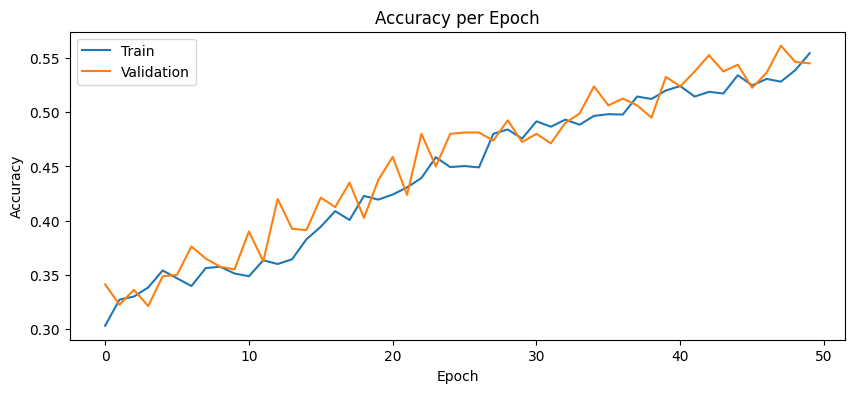

In [ ]:
# Visualización de la precisión del modelo por época
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

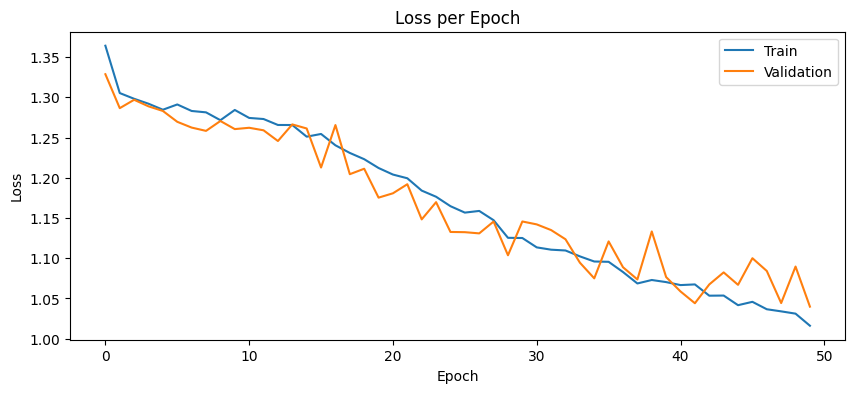

In [ ]:
# Visualización de la pérdida del modelo por época
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

# Paso 9: Calcular y mostrar la precisión del modelo en el conjunto de prueba


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5501 - loss: 1.0435
Precisión en el conjunto de prueba: 0.5450000166893005


# Paso 10: Evaluación del modelo y visualización de resultados


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


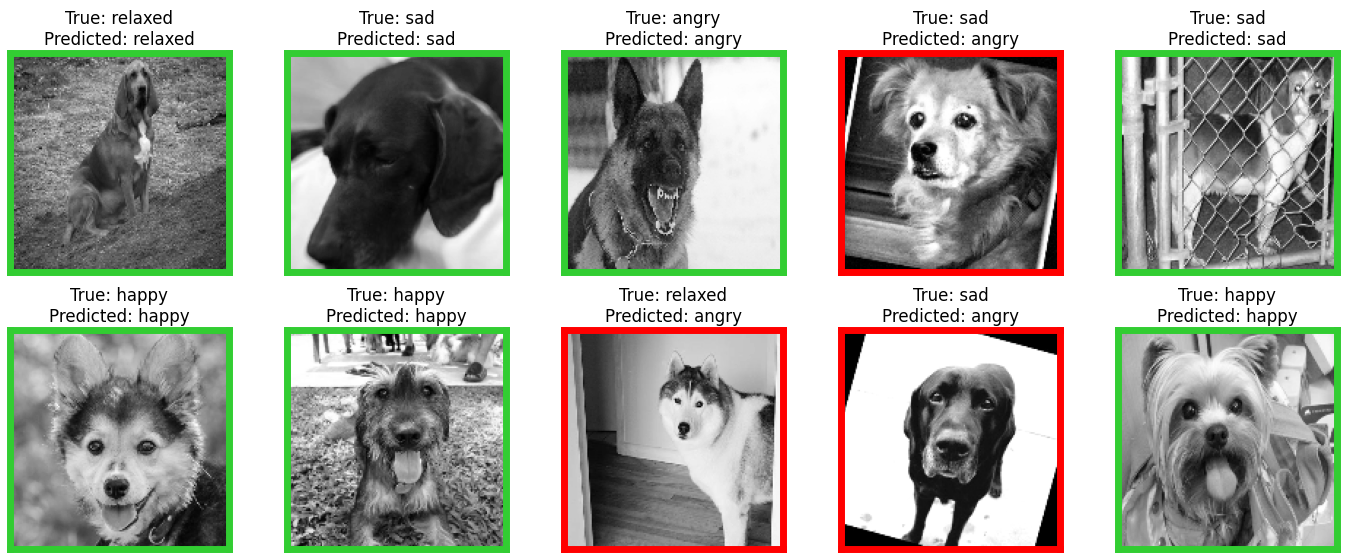

In [ ]:
random_indices = np.random.choice(len(X_test), size=10, replace=False)
sample_images = X_test[random_indices]
sample_labels = y_test[random_indices]
predictions = model.predict(sample_images)

emotion_labels = {0: "angry", 1: "happy", 2: "relaxed", 3: "sad"}

def get_border_color(true_emotion, predicted_emotion):
    if true_emotion == predicted_emotion:
        return 'limegreen'
    else:
        return 'red'

plt.figure(figsize=(14, 14))
for i in range(10):
    true_emotion = emotion_labels[sample_labels[i]]
    predicted_emotion = emotion_labels[np.argmax(predictions[i])]
    border_color = get_border_color(true_emotion, predicted_emotion)
    plt.subplot(5, 5, i + 1)
    plt.imshow(sample_images[i].reshape(150, 150), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    for axis in ['top', 'bottom', 'left', 'right']:
        plt.gca().spines[axis].set_linewidth(5)
        plt.gca().spines[axis].set_color(border_color)
    plt.title(f"True: {true_emotion}\nPredicted: {predicted_emotion}")
plt.tight_layout()
plt.show()

# Paso 11: Realización de predicción en una imagen nueva


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


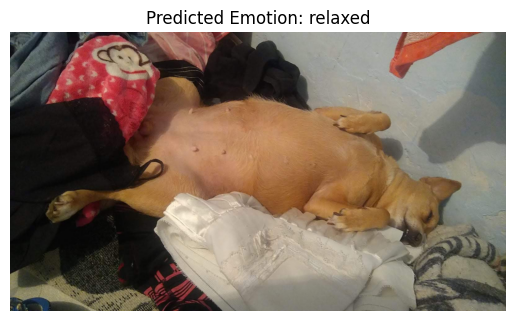

In [ ]:
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (150, 150))
    image = image / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

def predict_emotion(image_path):
    image = load_and_preprocess_image(image_path)
    prediction = model.predict(np.array([image]))
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    image_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f'Predicted Emotion: {predicted_emotion}')
    plt.show()

predict_emotion("minky.jpg")

# Paso 11: Guardar el modelo entrenado

In [ ]:
model.save('emotionDog.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir carpeta_DogEmotion

mkdir: cannot create directory ‘carpeta_salida’: File exists


In [ ]:
!tensorflowjs_converter --input_format keras emotionDog.h5 carpeta_salida

2024-04-26 19:06:35.179427: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/jax/_src/cloud_tpu_init.py:73: UserWarning: JAX_USE_PJRT_C_API_ON_TPU no longer has an effect (the new TPU runtime is always enabled now). Unset the environment variable to disable this warning.
  warnings.warn(
failed to lookup keras version from the file,
    this is likely a weight only file
